# Summary
Node classification to classify unknown node type based on neighbour nodes.

## Dataset
- Cora Citation Dataset
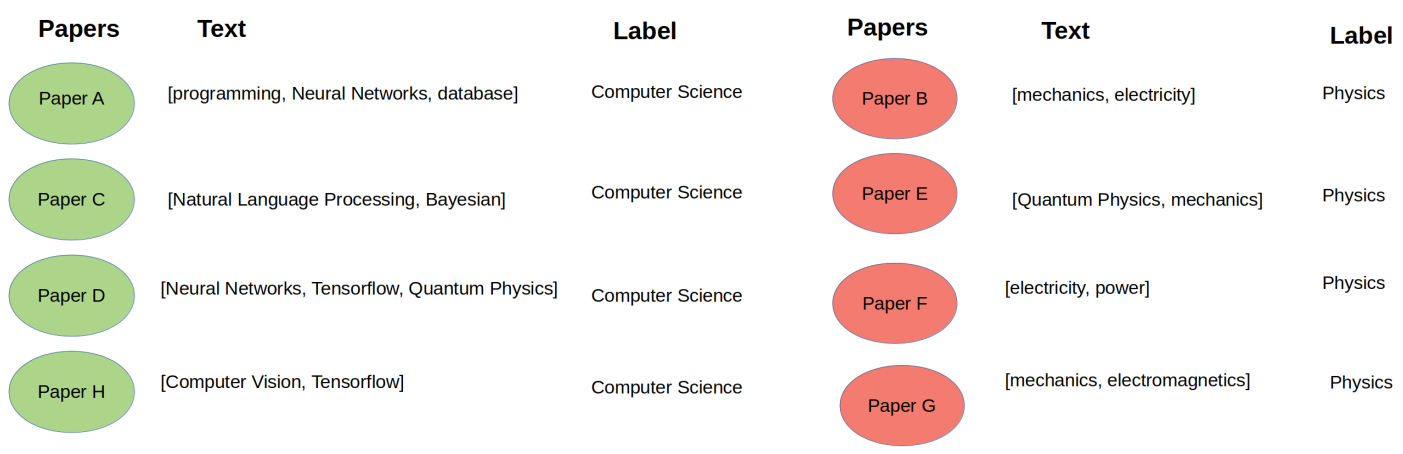
- Each nodes are class of the papers
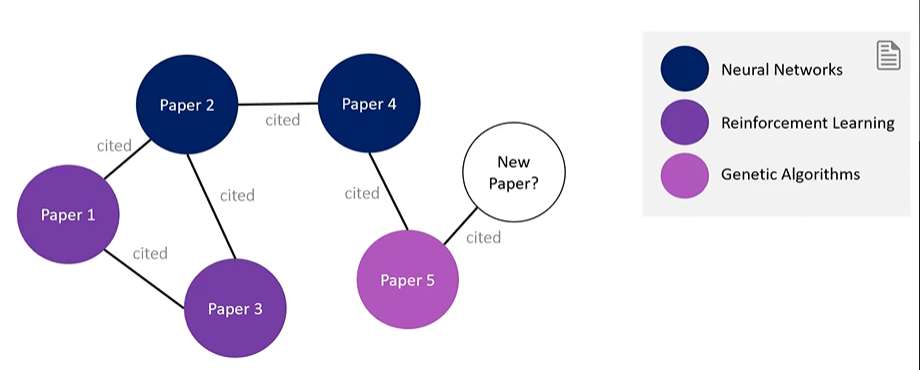
- Bag of word representation as node features




In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora',
                   transform=NormalizeFeatures())

Processing...
Done!


In [4]:
data = dataset[0]

In [6]:
data.x.shape

torch.Size([2708, 1433])

In [7]:
data.x[0][:50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [8]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [10]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [12]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train(x, y, edge_index, train_mask):
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(x, edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[train_mask], y[train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test(x, y, edge_index, test_mask):
      model.eval()
      out = model(x, edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[test_mask] == y[test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train(data.x, data.y, data.edge_index, data.train_mask)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9460
Epoch: 100, Loss: 1.6487
Epoch: 200, Loss: 1.4869
Epoch: 300, Loss: 1.4474
Epoch: 400, Loss: 1.3799
Epoch: 500, Loss: 1.3603
Epoch: 600, Loss: 1.3608
Epoch: 700, Loss: 1.3265
Epoch: 800, Loss: 1.3489
Epoch: 900, Loss: 1.3240
Epoch: 1000, Loss: 1.2993


c:\users\a101889\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


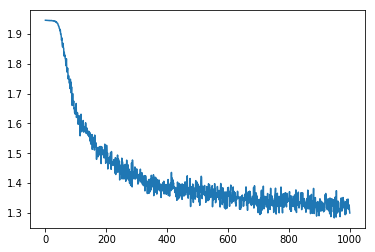

In [14]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [15]:
test_acc = test(data.x, data.y, data.edge_index, data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7420


torch.Size([2708, 7])


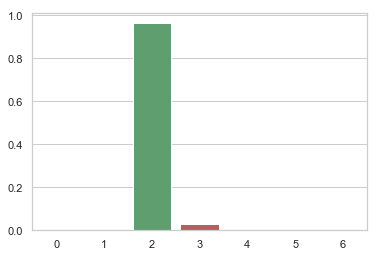

In [16]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

c:\users\a101889\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


TSNE Visualization finished.


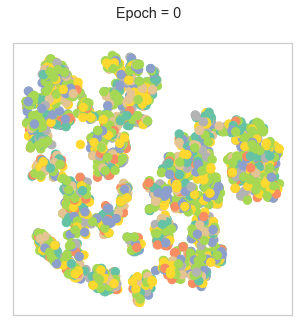

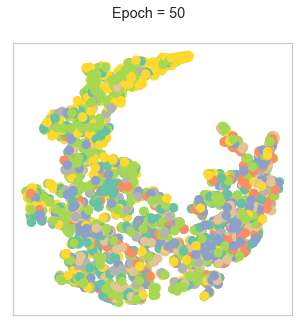

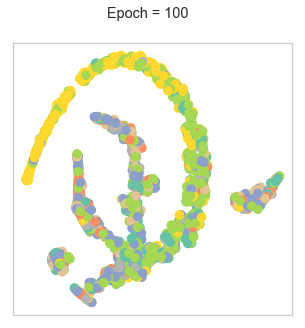

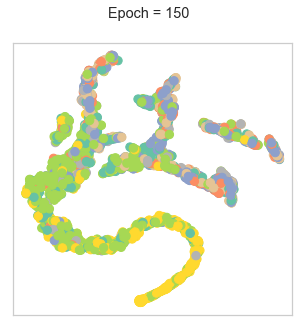

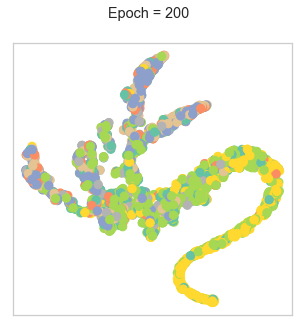

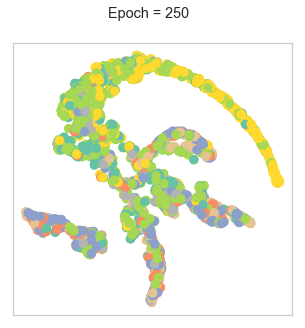

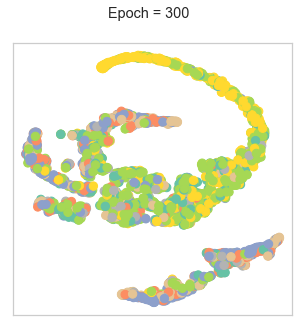

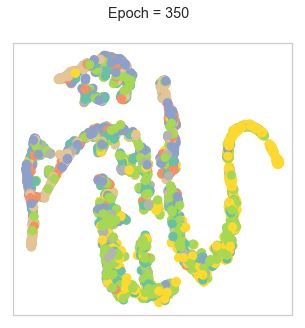

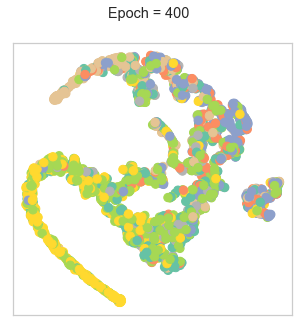

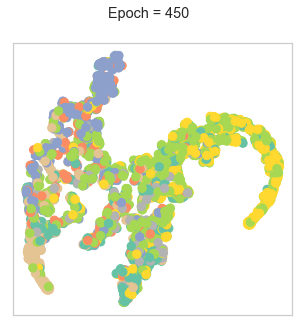

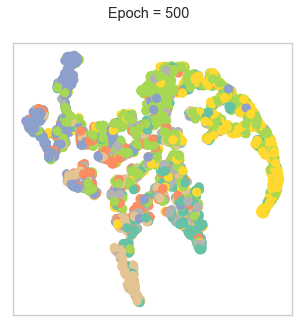

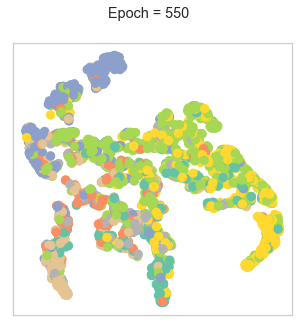

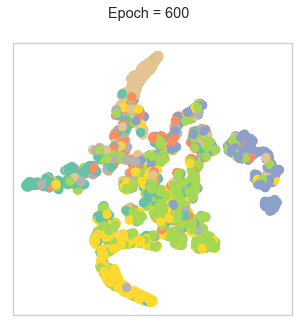

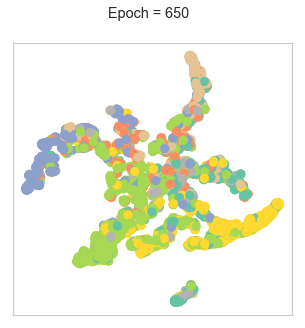

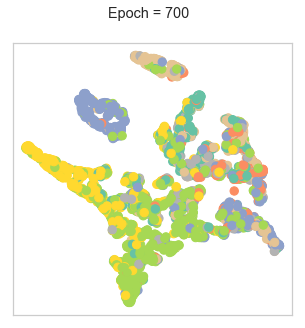

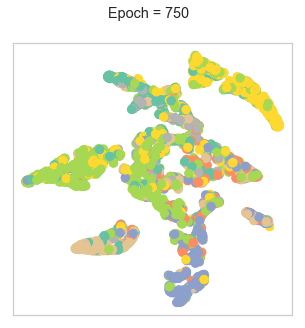

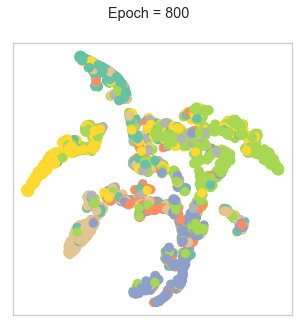

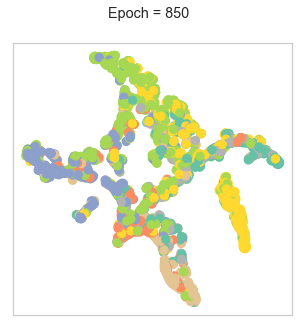

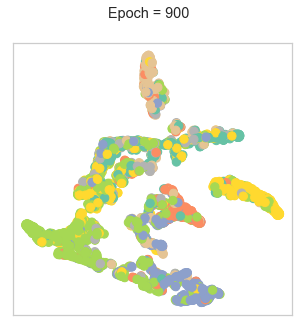

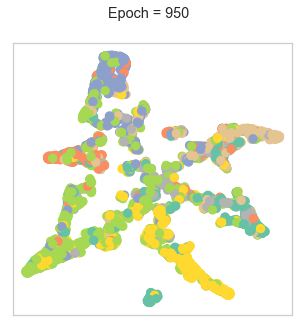

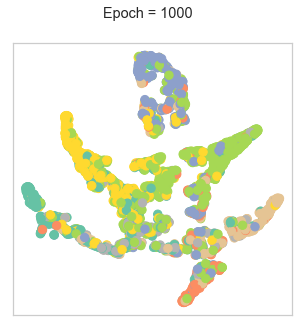

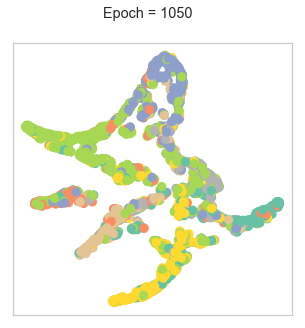

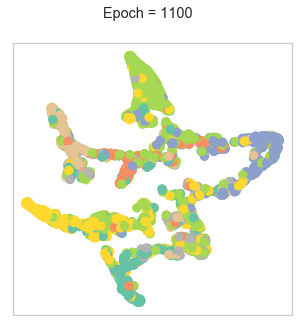

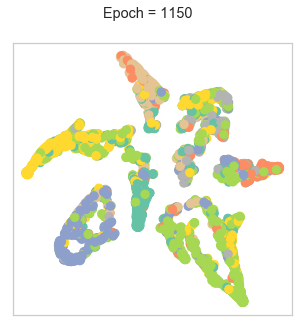

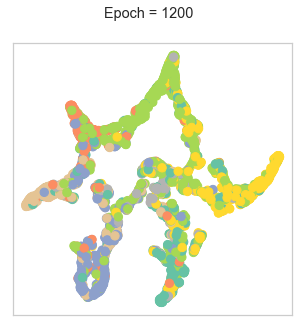

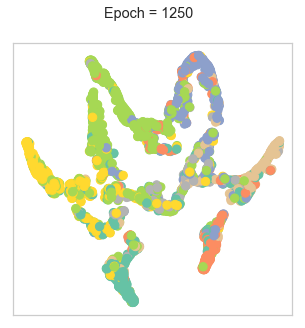

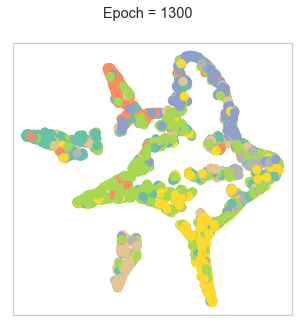

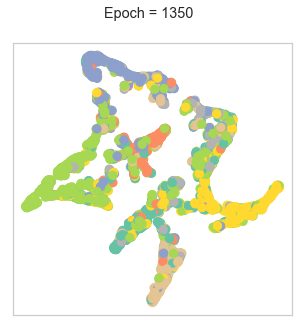

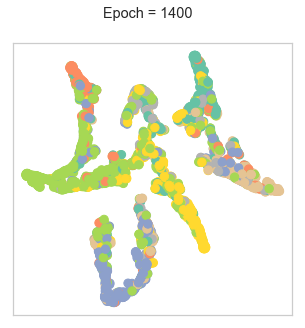

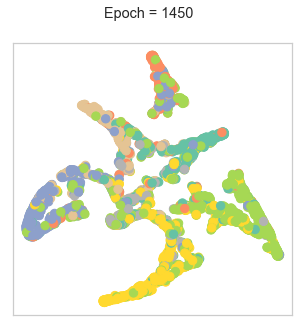

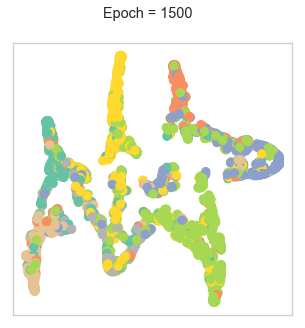

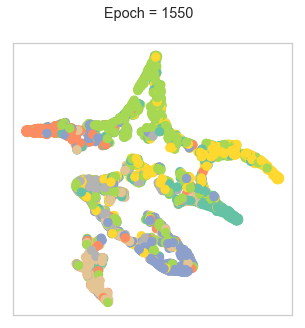

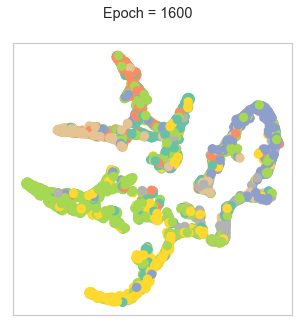

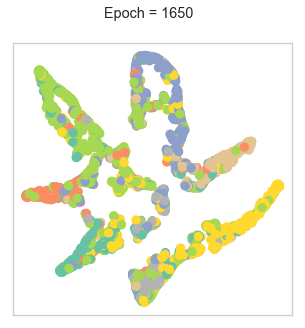

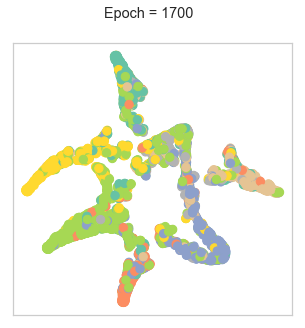

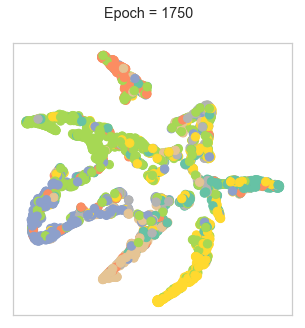

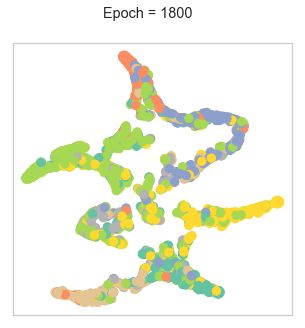

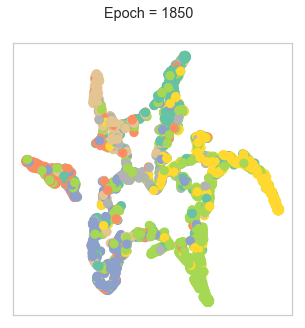

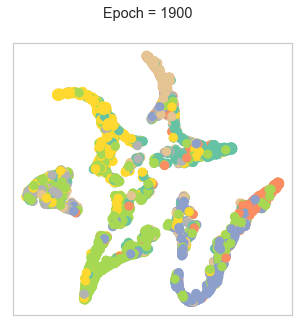

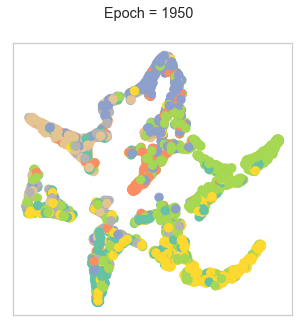

In [19]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train(data.x, data.y, data.edge_index, data.train_mask)
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")